# Airline analysis

The goal of this notebook is to create a logistic regression and k-nearest neighbors model which predicts the delay time upon departure of any given flight.

Our data is from:  https://www.kaggle.com/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018

# Imports

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import classification_report

from google.colab import drive
drive.mount('/content/drive')
drive_dir = '/content/drive/My Drive/Project4_airlines/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data

We import the data that we are using.

In [8]:
dtype_dict = {'OP_CARRIER_FL_NUM': np.uint16,'DEP_TIME': np.uint16, 'DEP_DELAY': np.int16, 'TAXI_OUT': np.uint8, 
              'WHEELS_OFF': np.uint16, 'WHEELS_ON': np.uint16, 'TAXI_IN': np.uint8, 'ARR_TIME': np.uint16, 
              'ARR_DELAY': np.int16,'AIR_TIME': np.uint16, 'DISTANCE': np.uint16, 'DEP_DELAY_Y/N': np.uint8,
              'ARR_DElAY_Y/N': np.uint8, 'YEAR': np.uint16, 'MONTH': np.uint8, 'DAY_OF_MONTH': np.uint8}

df = pd.read_csv(drive_dir + 'Data/all_years.csv', dtype=dtype_dict)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,12,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
df.head()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DEP_DELAY_Y/N,ARR_DELAY_Y/N,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,TIME_OF_DAY,AIRLINE_NAME
0,2009-01-06,DL,1192,ANC,SLC,100,233,93,10,243,810,7,735,817,42,0,0,275,224,207,2125,1,1,2009,1,6,Tuesday,night,Delta Airlines
1,2009-01-30,MQ,3692,GRR,DFW,1535,1557,22,12,1609,1714,7,1735,1721,-14,0,0,180,144,125,931,1,0,2009,1,30,Friday,afternoon,Envoy Air
2,2009-01-01,9E,2267,MEM,XNA,935,930,-5,15,945,1031,4,1052,1035,-17,0,0,77,65,46,258,0,0,2009,1,1,Thursday,morning,Endeavor Air
3,2009-01-02,DL,842,ATL,EWR,1340,1536,116,36,1612,1831,7,1600,1838,158,0,0,140,182,139,745,1,1,2009,1,2,Friday,afternoon,Delta Airlines
4,2009-01-01,EV,4985,JAX,CVG,1630,1623,-7,9,1632,1804,6,1831,1810,-21,0,0,121,107,92,614,0,0,2009,1,1,Thursday,afternoon,ExpressJet


This part of the code calculate the amount of rows.

In [10]:
df.shape[0]

906879

Checking if there is any missing value.

In [11]:
for c in df.columns:
    n_missing = df[c].isna().sum()
    pct_missing = n_missing / df.shape[0]
    if n_missing > 0:
      print(f'{c}: {n_missing} ({100*pct_missing:.2f}%) missing values')

AIRLINE_NAME: 9772 (1.08%) missing values


Dropping all the rows with missing values.

In [12]:
df = df.dropna(how='any')

Checking every column with their data types.

In [13]:
df.dtypes

FL_DATE                object
OP_CARRIER             object
OP_CARRIER_FL_NUM      uint16
ORIGIN                 object
DEST                   object
CRS_DEP_TIME           object
DEP_TIME               uint16
DEP_DELAY               int16
TAXI_OUT                uint8
WHEELS_OFF             uint16
WHEELS_ON              uint16
TAXI_IN                 uint8
CRS_ARR_TIME           object
ARR_TIME               uint16
ARR_DELAY               int16
CANCELLED              object
DIVERTED               object
CRS_ELAPSED_TIME       object
ACTUAL_ELAPSED_TIME    object
AIR_TIME               uint16
DISTANCE               uint16
DEP_DELAY_Y/N           uint8
ARR_DELAY_Y/N           int64
YEAR                   uint16
MONTH                   uint8
DAY_OF_MONTH            uint8
DAY_OF_WEEK            object
TIME_OF_DAY            object
AIRLINE_NAME           object
dtype: object

Mapping dictionaries and changing data types to reduce memory.

In [14]:
day_of_weekDict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
df['DAY_OF_WEEK'] = df['DAY_OF_WEEK'].map(day_of_weekDict)


timeOfDayDict = {'morning': 1, 'afternoon': 2, 'evening': 3, 'night': 4}
df['TIME_OF_DAY'] = df['TIME_OF_DAY'].map(timeOfDayDict)


carrierCode_dict = {'UA': 1,'AS': 2,'9E': 3,'B6': 4,'EV': 5,
    'F9': 6,'G4': 7,'HA': 8,'MQ':9,'NK': 10,'OH': 11,
    'OO':12,'VX': 13,'WN':14,'YV':15,'YX':16,'AA':17,
    'DL':18, 'XE': 19, 'FL': 20, 
    'US': 21, 'NW': 22}
df['OP_CARRIER'] = df['OP_CARRIER'].map(carrierCode_dict)


airlineName_dict2 = {'United Airlines':1, 'Alaska Airlines':2,'Endeavor Air':3,'JetBlue Airways':4,'ExpressJet':5,
    'Frontier Airlines': 6,'Allegiant Air': 7,'Hawaiian Airlines':8,'Envoy Air':9,'Spirit Airlines': 10,'PSA Airlines': 11,
    'SkyWest Airlines': 12,'Virgin America': 13,'Southwest Airlines': 14,'Mesa Airline': 15,'Republic Airways': 16,'American Airlines': 17,
    'Delta Airlines': 18, 'Delux Public Charter LLC dba JSX Air': 19, 'Air Large European Aviation Project Air Leap': 20, 
    'Puerto Rico International Airlines Inc.': 21, 'Northwest Airlines': 22}
df['AIRLINE_NAME'] = df['AIRLINE_NAME'].map(airlineName_dict2)


df['OP_CARRIER'] = df['OP_CARRIER'].astype(np.uint8)
df['DAY_OF_WEEK'] = df['DAY_OF_WEEK'].astype(np.uint8)
df['TIME_OF_DAY'] = df['TIME_OF_DAY'].astype(np.uint8)
df['AIRLINE_NAME'] = df['AIRLINE_NAME'].astype(np.uint8)


df['CRS_ELAPSED_TIME'] = df['CRS_ELAPSED_TIME'].replace(['Unknown'], '0')
df['CRS_DEP_TIME'] = df['CRS_DEP_TIME'].replace(['Unknown'], '0')
df['CRS_ARR_TIME'] = df['CRS_ARR_TIME'].replace(['Unknown'], '0')
df['ACTUAL_ELAPSED_TIME'] = df['ACTUAL_ELAPSED_TIME'].replace(['Unknown'], '0')
df['CRS_ELAPSED_TIME'] = pd.to_numeric(df['CRS_ELAPSED_TIME'])
df['CRS_DEP_TIME'] = pd.to_numeric(df['CRS_DEP_TIME'])
df['CRS_ARR_TIME'] = pd.to_numeric(df['CRS_ARR_TIME'])
df['ACTUAL_ELAPSED_TIME'] = pd.to_numeric(df['ACTUAL_ELAPSED_TIME'])


df['CRS_ELAPSED_TIME'] = df['CRS_ELAPSED_TIME'].astype(int)
df['CRS_DEP_TIME'] = df['CRS_DEP_TIME'].astype(int)
df['CRS_ARR_TIME'] = df['CRS_ARR_TIME'].astype(int)
df['ACTUAL_ELAPSED_TIME'] = df['ACTUAL_ELAPSED_TIME'].astype(int)


# Models

# Linear regression

This part of the code we are training or data to make modeling.

In [15]:

def train_test_valid(df):
  train_df, test_df = train_test_split(df, test_size=0.3) #, random_state = 42)
  train_df, valid_df = train_test_split(train_df, test_size=int(0.1*df.shape[0]))#, random_state = 42)

  return train_df, test_df, valid_df

In [16]:
train_df, test_df, valid_df = train_test_valid(df)

We are creating a function run the linear regression as the best fit.

In [17]:

def lr_fit(df, train_df, test_df, valid_df):

  lr = LinearRegression()


  X_train = train_df[['OP_CARRIER', 'OP_CARRIER_FL_NUM','CRS_DEP_TIME', 'DEP_TIME', 'TAXI_OUT', 
          'WHEELS_OFF','WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME','CRS_ELAPSED_TIME', 
          'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'YEAR', 'MONTH', 'DAY_OF_MONTH',
          'DAY_OF_WEEK', 'TIME_OF_DAY', 'AIRLINE_NAME']]
  y_train = train_df['DEP_DELAY']

  X_valid = valid_df[['OP_CARRIER', 'OP_CARRIER_FL_NUM','CRS_DEP_TIME', 'DEP_TIME', 'TAXI_OUT', 
          'WHEELS_OFF','WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME','CRS_ELAPSED_TIME', 
          'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'YEAR', 'MONTH', 'DAY_OF_MONTH',
          'DAY_OF_WEEK', 'TIME_OF_DAY', 'AIRLINE_NAME']]
  y_valid = valid_df['DEP_DELAY']

  X_test = test_df[['OP_CARRIER', 'OP_CARRIER_FL_NUM','CRS_DEP_TIME', 'DEP_TIME', 'TAXI_OUT', 
          'WHEELS_OFF','WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME','CRS_ELAPSED_TIME', 
          'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'YEAR', 'MONTH', 'DAY_OF_MONTH',
          'DAY_OF_WEEK', 'TIME_OF_DAY', 'AIRLINE_NAME']]
  y_test = test_df['DEP_DELAY']

  lr.fit(X_train, y_train)

  return lr, X_train, y_train, X_valid, y_valid, X_test, y_test

We create a function to plot the linear regression which the x-axis is the actual time and the y-axis is the prediction time.

In [18]:

def lr_scatterplot(lr, X_test, y_test):
    fig = plt.figure(figsize=(12, 10))
    
    test_pred = lr.predict(X_test)
    plt.scatter(y_test, test_pred)

    plt.xlabel('Actual Time')
    plt.ylabel('Predicted Time')
    plt.title(f'Actual vs predicted using linear regression: R^2 = {np.corrcoef(y_test, test_pred)[0,1]**2:.3f}');

We are calling the variables to fit in the linear regression.

In [19]:
all_lr, X_train, y_train, X_valid, y_valid, X_test, y_test = lr_fit(df,train_df,test_df,valid_df)

Here we are creating the different scatterplot to see the results.

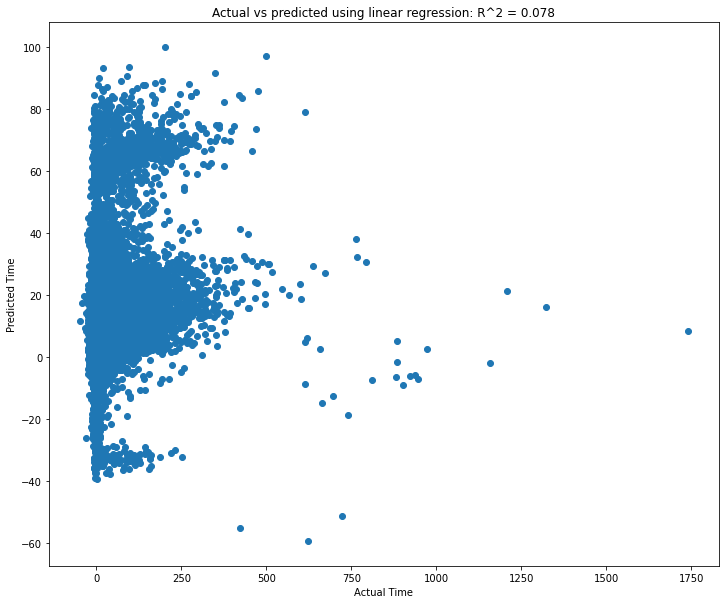

In [20]:
lr_scatterplot(all_lr, X_valid, y_valid)

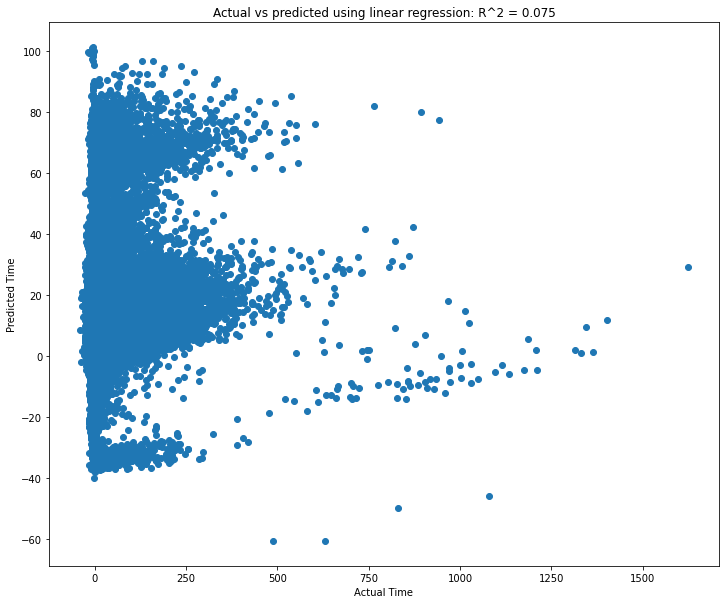

In [21]:
lr_scatterplot(all_lr, X_test, y_test)

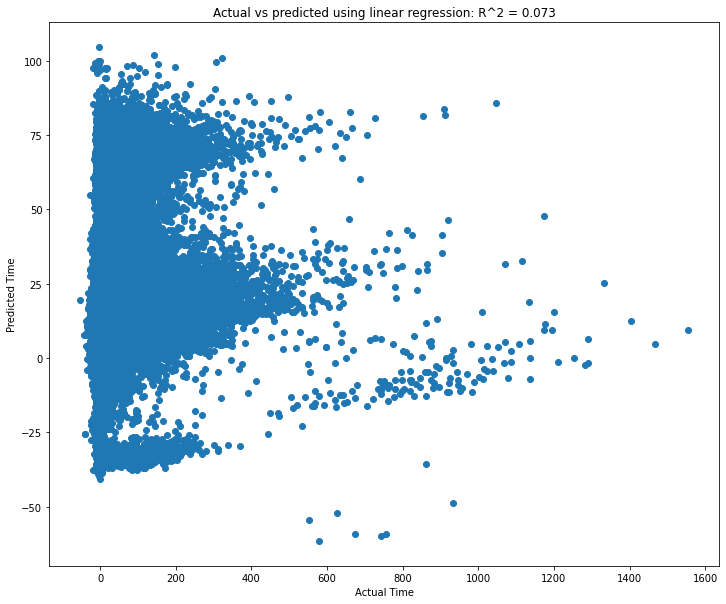

In [22]:
lr_scatterplot(all_lr, X_train, y_train)

# K Neighbors Regressor

We will use this dataframe below for all of our models.

In [23]:
columns = ['FL_DATE', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE', 'YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 
           'TIME_OF_DAY', 'AIRLINE_NAME']
df_new = df[columns]

Now we must encode it so that we can use all of the columns. Most models don't work on nonnumerical data.

In [24]:
for c in df_new.columns:
  if c != 'DEP_DELAY':  
    if df_new[c].dtype == object:  #If it is a string, then encode it. 
        try:  
            le = LabelEncoder()           
            le.fit(df_new[c].unique())    
            df_new[c] = le.transform(df_new[c])  
        except Exception as e:         
            print(c)         
            print(e)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Now we can split the data to training and testing data. This will also be used for all the models.

In [25]:
y = df['DEP_DELAY']
X = df_new

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=1/3, random_state=85)

Fit our model

In [26]:
nn_clf = KNeighborsRegressor()
nn_clf.fit(train_X, train_y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [27]:
preds = nn_clf.predict(test_X)

In [ ]:
y_pred_nn = nn_clf.predict(test_X)
print(mean_squared_error(test_y, y_pred_nn))